# Import and global variable

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [14]:
import datetime
now  = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print(datetime.datetime.now())
print(now)

2021-02-02 05:36:39.266620
20210202_053639


In [15]:
xl_writer = pd.ExcelWriter(f"covid19_world_data_{now}.xlsx")

# Data

data from https://github.com/CSSEGISandData/COVID-19

or

https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

# Cases

In [16]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

In [17]:
df = pd.read_csv(url)

In [18]:
df.to_excel(xl_writer, "raw")

In [19]:
df.drop(columns=['Lat', 'Long'], inplace=True)

In [20]:
df.head()

Province/State Country/Region  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
0            NaN    Afghanistan        0        0        0        0        0   
1            NaN        Albania        0        0        0        0        0   
2            NaN        Algeria        0        0        0        0        0   
3            NaN        Andorra        0        0        0        0        0   
4            NaN         Angola        0        0        0        0        0   

   1/27/20  1/28/20  1/29/20  ...  1/22/21  1/23/21  1/24/21  1/25/21  \
0        0        0        0  ...    54483    54559    54595    54672   
1        0        0        0  ...    70655    71441    72274    72812   
2        0        0        0  ...   105124   105369   105596   105854   
3        0        0        0  ...     9416     9499     9549     9596   
4        0        0        0  ...    19269    19367    19399    19476   

   1/26/21  1/27/21  1/28/21  1/29/21  1/30/21  1/31/21  
0    54750    54854    54891    54939    55008    55023  
1    73691    74567    75454    76350    77251    78127  
2   106097   106359   106610   106887   107122   107339  
3     9638     9716     9779     9837     9885     9937  
4    19553    19580    19672    19723    19782    19796  

[5 rows x 378 columns]

In [21]:
countries = df["Country/Region"].unique()

In [22]:
countries.sort()

In [23]:
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [24]:
province = df["Province/State"]

In [25]:
province.dropna(inplace=True)

In [26]:
province = province.unique()

In [27]:
province.sort()

In [28]:
province

array(['Alberta', 'Anguilla', 'Anhui', 'Aruba',
       'Australian Capital Territory', 'Beijing', 'Bermuda',
       'Bonaire, Sint Eustatius and Saba', 'British Columbia',
       'British Virgin Islands', 'Cayman Islands', 'Channel Islands',
       'Chongqing', 'Curacao', 'Diamond Princess',
       'Falkland Islands (Malvinas)', 'Faroe Islands', 'French Guiana',
       'French Polynesia', 'Fujian', 'Gansu', 'Gibraltar',
       'Grand Princess', 'Greenland', 'Guadeloupe', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Isle of Man',
       'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning', 'Macau', 'Manitoba',
       'Martinique', 'Mayotte', 'Montserrat', 'New Brunswick',
       'New Caledonia', 'New South Wales', 'Newfoundland and Labrador',
       'Ningxia', 'Northern Territory', 'Northwest Territories',
       'Nova Scotia', 'Nunavut', 'Ontario', 'Prince Edward Island',
       'Qinghai', 'Quebec', 

In [29]:
def extract_data(data_frame, country, region=None, groupby=False):
    if groupby:
        s = data_frame[data_frame["Country/Region"] == country].groupby(by=["Country/Region",]).sum().stack().droplevel(level=0)
    else:
        d = data_frame[(data_frame["Country/Region"] == country)]
        if region:
            s = d[d["Province/State"] == region].drop(columns=["Province/State", "Country/Region"]).stack().droplevel(level=0)
        else:
            s = d[d["Province/State"].isna()].drop(columns=["Province/State", "Country/Region"]).stack().droplevel(level=0)
    s.index = pd.to_datetime(s.index)
    df = s.to_frame()
    if region:
        df.columns = [region,]
    else:
        df.columns = [country,]
    df["day_of_year"] = df.index.dayofyear
    df.reset_index(inplace=True)
    df.columns = ['date'] + list(df.columns[1:])
    return df.set_index(['date', 'day_of_year'])

In [30]:
def plot_data(dataframe, logx=False, logy=False, **kwargs):
    if logx:
        df = dataframe.reset_index(level=0, drop=True)
        ax = df.plot(logx=logx, logy=logy, **kwargs)
    else:
        df = dataframe.reset_index(level=1, drop=True)
        ax = df.plot(logy=logy, **kwargs)
    return ax

In [31]:
def add(df1, df2, country):
    try:
        df = pd.concat([extract_data(df1, country), extract_data(df2, country)], axis=1)
    except KeyError:
        df = pd.concat([df1, df2], axis=1)
    df.country = country
    df.columns = ["cases", "deaths"]
    df["daily_cases"] = df["cases"].diff()
    df.loc[df["daily_cases"].isna(), "daily_cases"] = 0
    df["daily_cases_s"] = signal.savgol_filter(df["cases"], 11, 3, deriv=1)
    df["daily_death"] = df["deaths"].diff()
    df.loc[df["daily_death"].isna(), "daily_death"] = 0
    df["daily_death_s"] = signal.savgol_filter(df["deaths"], 11, 3, deriv=1)
    return df

In [32]:
def plot_daily(data):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 13))
    dataframe = data.copy()
    dataframe.reset_index("day_of_year", drop=True, inplace=True)
    dataframe["cases"].plot(color="r", 
                            title=f"Cases in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax1)
    dataframe["daily_cases"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax1)  
    dataframe["daily_cases_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax1)
    #
    dataframe["deaths"].plot(color="r", 
                            title=f"Deaths in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax2)
    dataframe["daily_death"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax2)  
    dataframe["daily_death_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax2)


# Switzerland

In [33]:
swiss = extract_data(df, "Switzerland")

<AxesSubplot:xlabel='date'>

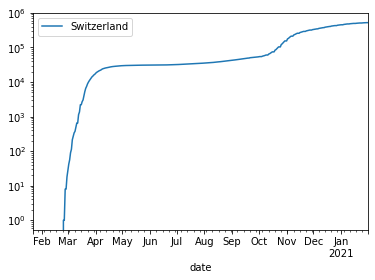

In [34]:
plot_data(swiss, logy=True)

<AxesSubplot:xlabel='date'>

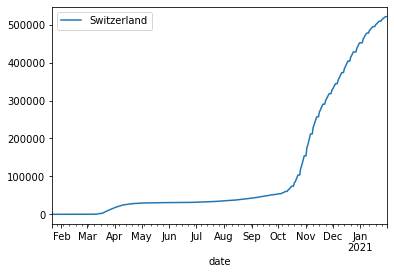

In [35]:
plot_data(swiss)

# Europe

In [36]:
italy = extract_data(df, "Italy")

In [37]:
france = extract_data(df, "France")

In [38]:
uk = extract_data(df, "United Kingdom")

In [39]:
spain = extract_data(df, "Spain")

In [40]:
germany =  extract_data(df, "Germany")

In [41]:
austria =  extract_data(df, "Austria")

In [42]:
europe = pd.concat([swiss, italy, france, germany, austria, spain, uk], axis=1)

In [43]:
# europe.columns = ['Switzerland', 'Italy', 'France', 'Germany', 'Austria', 'Spain', 'UK']

In [44]:
europe

Switzerland    Italy   France  Germany  Austria  \
date       day_of_year                                                    
2020-01-22 22                     0        0        0        0        0   
2020-01-23 23                     0        0        0        0        0   
2020-01-24 24                     0        0        2        0        0   
2020-01-25 25                     0        0        3        0        0   
2020-01-26 26                     0        0        3        0        0   
...                             ...      ...      ...      ...      ...   
2021-01-27 27                517705  2501147  3097374  2179679   408781   
2021-01-28 28                519404  2515507  3097374  2194562   410230   
2021-01-29 29                521320  2529070  3143417  2207393   411730   
2021-01-30 30                521320  2541783  3167274  2224911   413208   
2021-01-31 31                521320  2553032  3186354  2225659   414398   

                          Spain  United Kingdom  
date       day_of_year                           
2020-01-22 22                 0               0  
2020-01-23 23                 0               0  
2020-01-24 24                 0               0  
2020-01-25 25                 0               0  
2020-01-26 26                 0               0  
...                         ...             ...  
2021-01-27 27           2670102         3715054  
2021-01-28 28           2705001         3743734  
2021-01-29 29           2743119         3772813  
2021-01-30 30           2743119         3796088  
2021-01-31 31           2743119         3817176  

[376 rows x 7 columns]

<AxesSubplot:xlabel='date'>

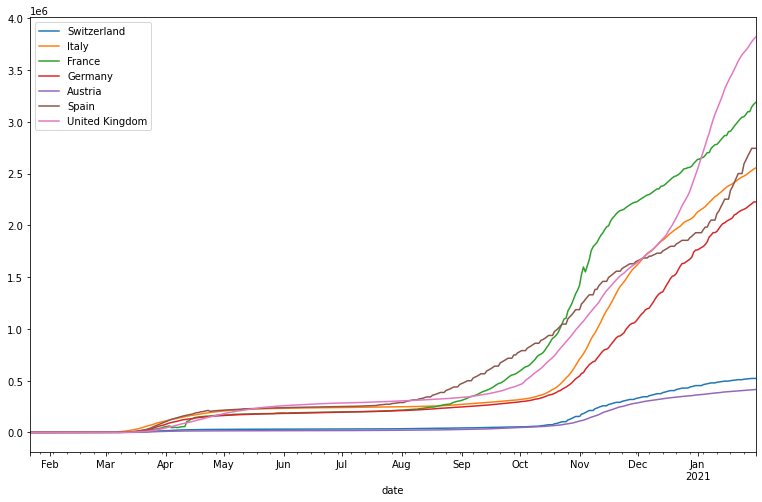

In [45]:
plot_data(europe, figsize=(13, 8))

<AxesSubplot:xlabel='date'>

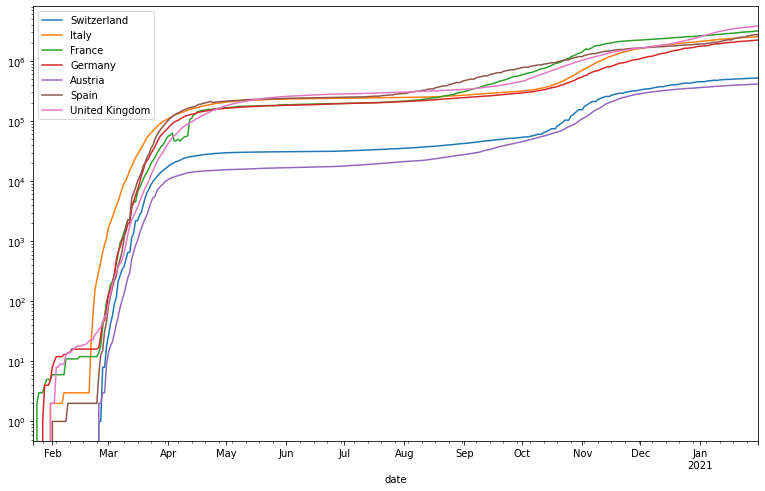

In [46]:
plot_data(europe, logy=True, figsize=(13, 8))

# USA

In [47]:
us = extract_data(df, country="US", groupby=True)

<AxesSubplot:xlabel='date'>

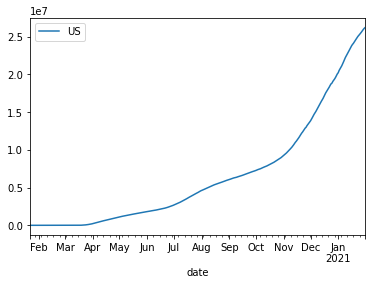

In [48]:
plot_data(us)

<AxesSubplot:xlabel='date'>

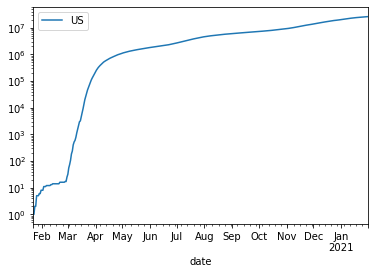

In [49]:
plot_data(us, logy=True)

# Europe + USA

In [50]:
comp_us = pd.concat([europe, us], axis=1)

<AxesSubplot:xlabel='date'>

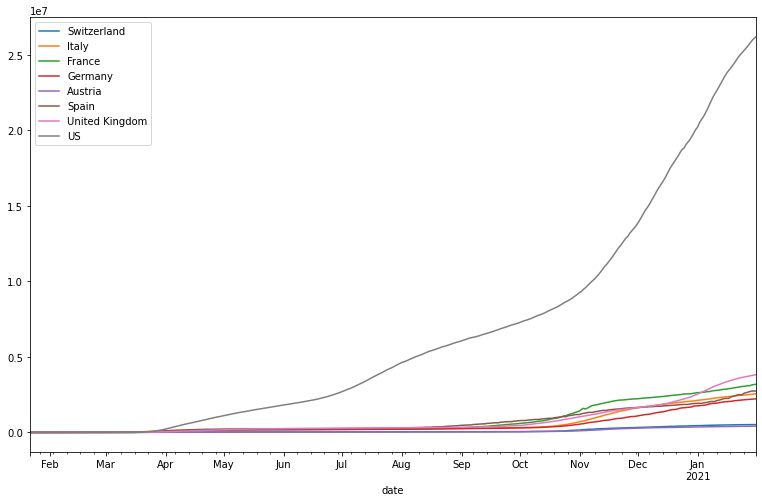

In [51]:
plot_data(comp_us, figsize=(13, 8))

<AxesSubplot:xlabel='date'>

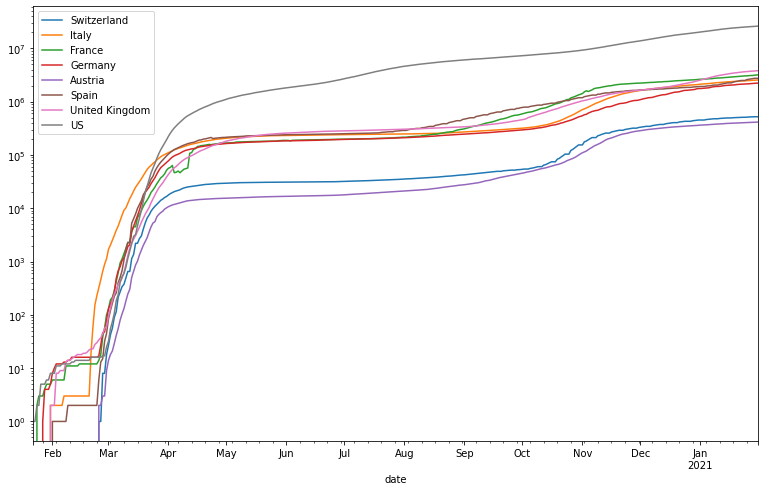

In [52]:
plot_data(comp_us, logy=True, figsize=(13, 8))

# Worldwide

In [53]:
world = df.sum(axis=0).drop(index=['Country/Region']).to_frame()

In [54]:
world.index = pd.to_datetime(world.index)

In [55]:
world["day_of_year"] = world.index.dayofyear

In [56]:
world.reset_index(inplace=True)

In [57]:
world.columns = ["date", "world_cases", "day_of_year"]

In [58]:
world.set_index(["date", "day_of_year"], inplace=True)

<AxesSubplot:xlabel='date'>

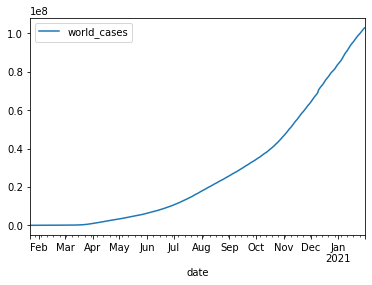

In [59]:
plot_data(world)

<AxesSubplot:xlabel='date'>

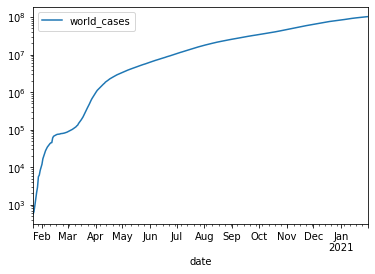

In [60]:
plot_data(world, logy=True)

# Iran

In [61]:
iran = extract_data(df, "Iran")

<AxesSubplot:xlabel='date'>

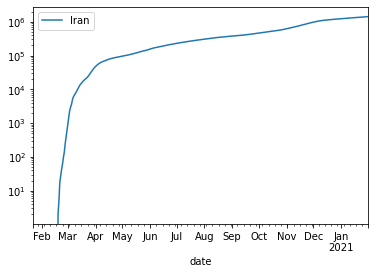

In [62]:
plot_data(iran, logy=True)

In [63]:
comp_iran = pd.concat([comp_us, iran], axis=1)

<AxesSubplot:xlabel='date'>

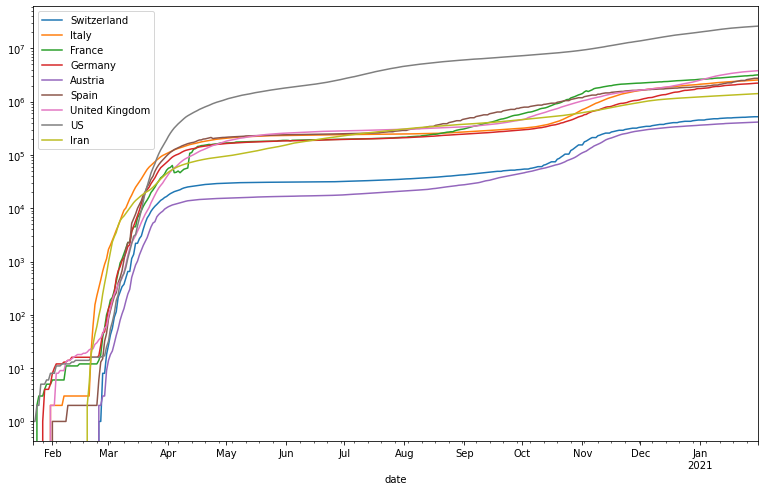

In [64]:
plot_data(comp_iran, logy=True, figsize=(13, 8))

# China

In [65]:
china = extract_data(df, "China", groupby=True)

<AxesSubplot:xlabel='date'>

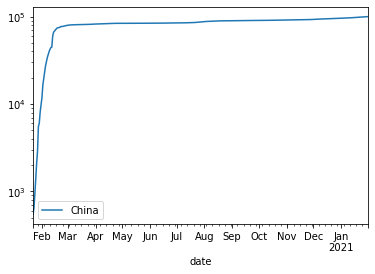

In [66]:
plot_data(china, logy=True)

In [67]:
comp_china = pd.concat([china, comp_us], axis=1)

<AxesSubplot:xlabel='date'>

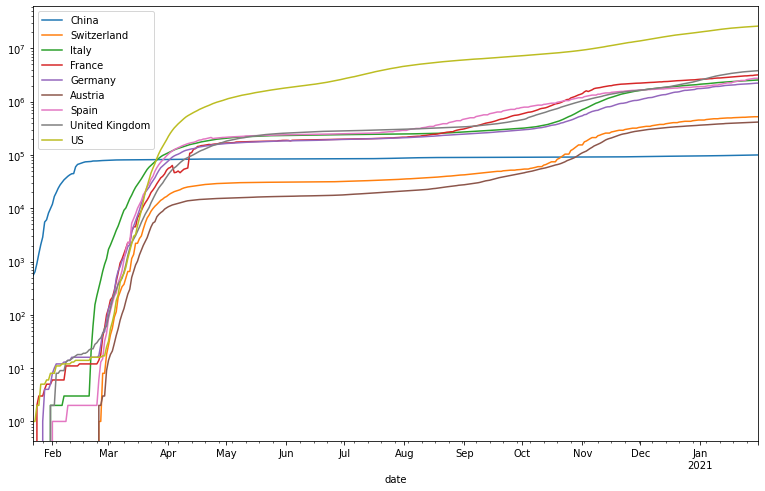

In [68]:
plot_data(comp_china, logy=True, figsize=(13, 8))

# Shanghai

In [69]:
shanghai = extract_data(df, "China", "Shanghai")

<AxesSubplot:xlabel='date'>

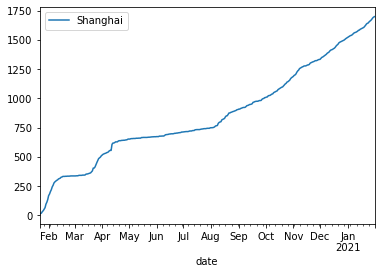

In [70]:
plot_data(shanghai)

<AxesSubplot:xlabel='date'>

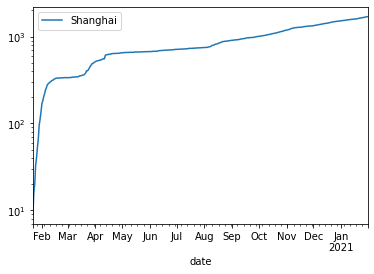

In [71]:
plot_data(shanghai, logy=True)

# Singapore

In [72]:
singapore = extract_data(df, "Singapore")

<AxesSubplot:xlabel='date'>

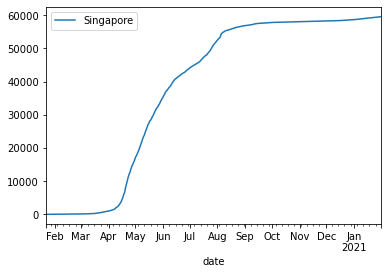

In [73]:
plot_data(singapore)

<AxesSubplot:xlabel='date'>

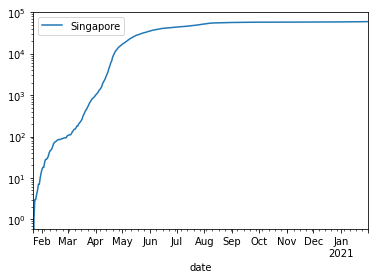

In [74]:
plot_data(singapore, logy=True)

# South Korea

In [75]:
kr = extract_data(df, "Korea, South")

<AxesSubplot:xlabel='date'>

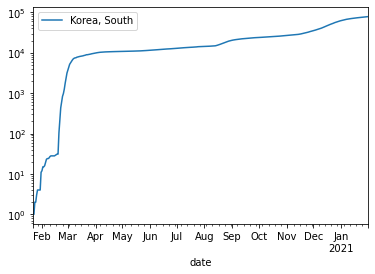

In [76]:
plot_data(kr, logy=True)

# South Central China

## Hong Kong

In [77]:
hong_kong = extract_data(df,"China", "Hong Kong")

<AxesSubplot:xlabel='date'>

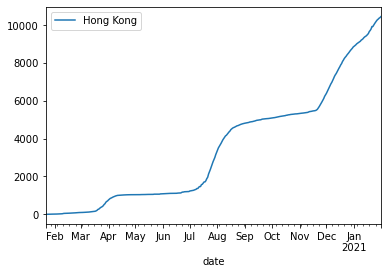

In [78]:
plot_data(hong_kong)

<AxesSubplot:xlabel='date'>

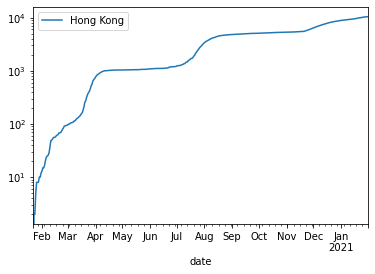

In [79]:
plot_data(hong_kong, logy=True)

## Hubei (Wuhan)

In [80]:
hubei = extract_data(df,"China", "Hubei")

<AxesSubplot:xlabel='date'>

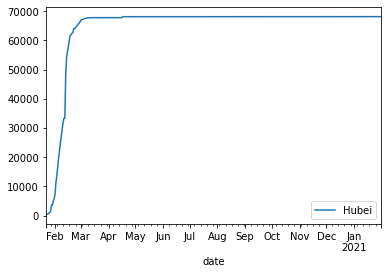

In [81]:
plot_data(hubei)

<AxesSubplot:xlabel='date'>

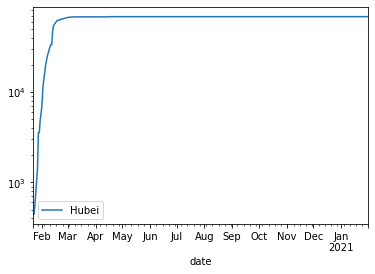

In [82]:
plot_data(hubei, logy=True)

## Henan

In [83]:
henan = extract_data(df, "China", "Henan")

<AxesSubplot:xlabel='date'>

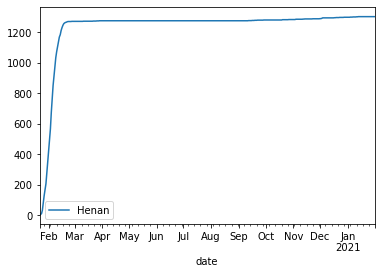

In [84]:
plot_data(henan)

<AxesSubplot:xlabel='date'>

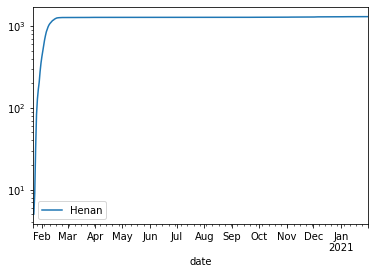

In [85]:
plot_data(henan, logy=True)

## Hunan

In [86]:
hunan = extract_data(df, "China", "Hunan")

<AxesSubplot:xlabel='date'>

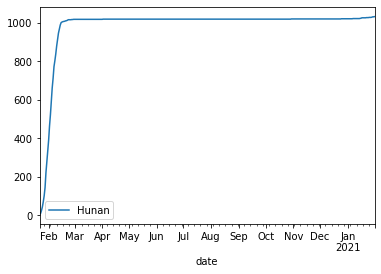

In [87]:
plot_data(hunan)

<AxesSubplot:xlabel='date'>

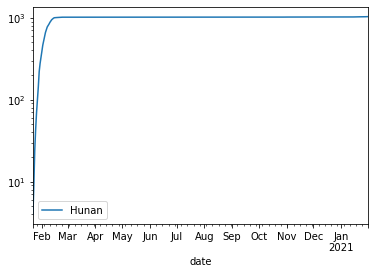

In [88]:
plot_data(hunan, logy=True)

## Guangdong

In [89]:
guangdong = extract_data(df, "China", "Guangdong")

<AxesSubplot:xlabel='date'>

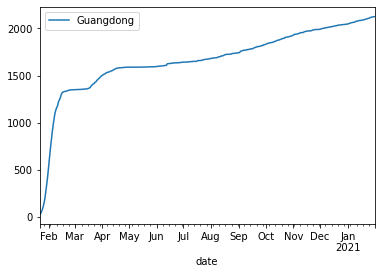

In [90]:
plot_data(guangdong)

<AxesSubplot:xlabel='date'>

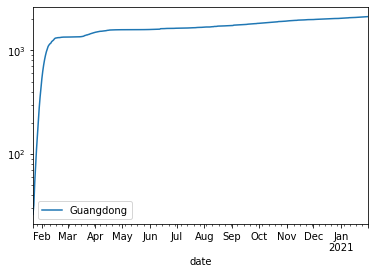

In [91]:
plot_data(guangdong, logy=True)

## Guangxi

In [92]:
guangxi = extract_data(df, "China", "Guangxi")

<AxesSubplot:xlabel='date'>

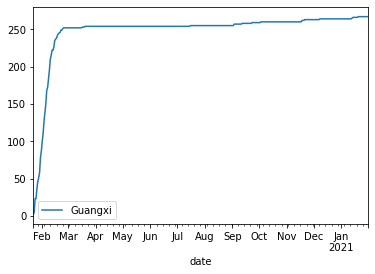

In [93]:
plot_data(guangxi)

<AxesSubplot:xlabel='date'>

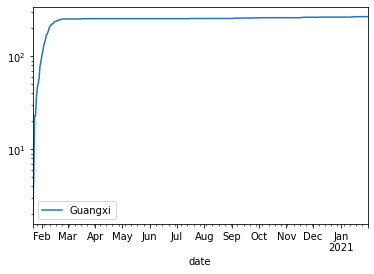

In [94]:
plot_data(guangxi, logy=True)

# South-Asia

In [95]:
south_asia = pd.concat([singapore, hong_kong, shanghai, kr, italy], axis=1)

<AxesSubplot:xlabel='date'>

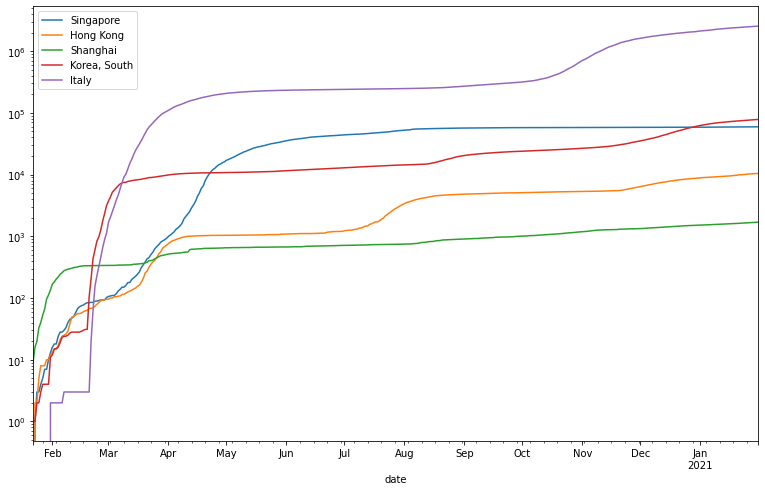

In [96]:
plot_data(south_asia, logy=True, figsize=(13, 8))

# North Europe

In [97]:
sweden = extract_data(df, "Sweden")

In [98]:
norway = extract_data(df, "Norway")

In [99]:
danemark = extract_data(df, 'Danemark')

In [100]:
finland = extract_data(df, 'Finland')

In [101]:
nl = extract_data(df, "Netherlands")

In [102]:
nort_eu = pd.concat([swiss, germany, sweden, norway, danemark, finland, nl], axis=1)

<AxesSubplot:xlabel='date'>

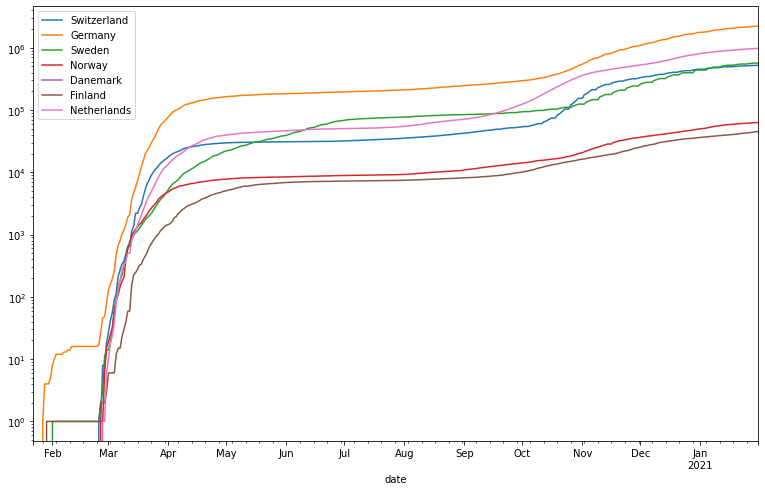

In [103]:
plot_data(nort_eu, logy=True, figsize=(13, 8))

# Death

In [104]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [105]:
death = pd.read_csv(url)

In [106]:
death.head()

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  1/22/21  1/23/21  1/24/21  \
0        0        0        0        0  ...     2370     2373     2378   
1        0        0        0        0  ...     1303     1310     1315   
2        0        0        0        0  ...     2856     2861     2863   
3        0        0        0        0  ...       93       96       96   
4        0        0        0        0  ...      452      457      459   

   1/25/21  1/26/21  1/27/21  1/28/21  1/29/21  1/30/21  1/31/21  
0     2385     2389     2389     2397     2399     2400     2400  
1     1324     1332     1339     1350     1358     1369     1380  
2     2866     2871     2877     2881     2884     2888     2891  
3       97       97       98      100      100      101      101  
4      461      462      462      464      464      464      466  

[5 rows x 380 columns]

In [107]:
death.drop(columns=['Lat', 'Long'], inplace=True)

In [108]:
uk_death = extract_data(death, "United Kingdom")

In [109]:
us_death = extract_data(death, "US", groupby=True)

In [110]:
it_death = extract_data(death, "Italy")

In [111]:
es_death = extract_data(death, "Spain")

In [112]:
de_death = extract_data(death, "Germany")

In [113]:
cn_death = extract_data(death, "China", groupby=True)

In [114]:
fr_death = extract_data(death, "France")

In [115]:
ch_death = extract_data(death, "Switzerland")

In [116]:
comp_death = pd.concat([it_death, uk_death, us_death, es_death, de_death, cn_death, ch_death, fr_death], axis=1)

<AxesSubplot:xlabel='date'>

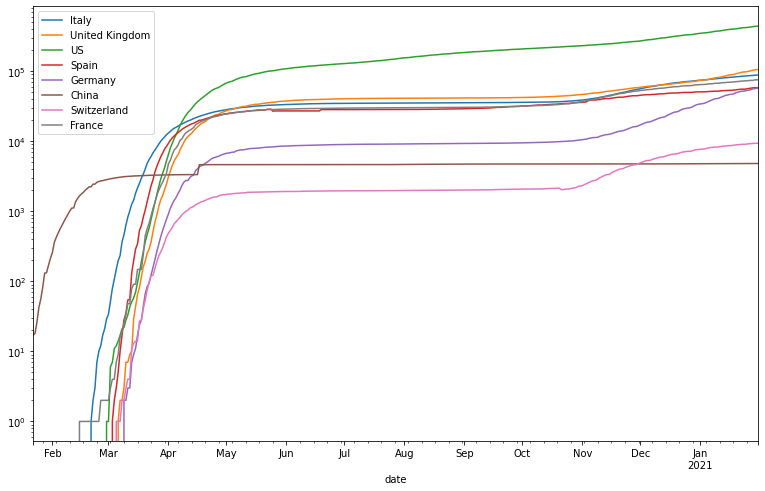

In [117]:
plot_data(comp_death, logy=True, figsize=(13, 8))

<AxesSubplot:title={'center':'Deaths'}, xlabel='date'>

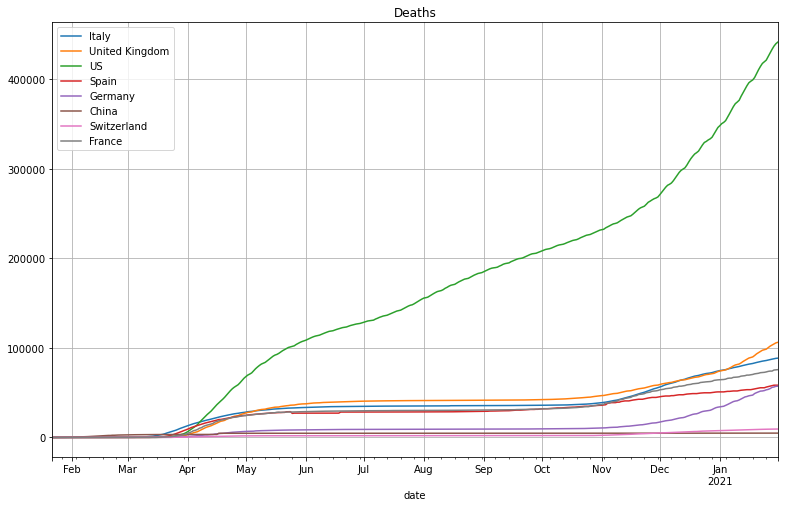

In [118]:
plot_data(comp_death, figsize=(13, 8), title="Deaths", grid=True)

In [119]:
world_death = death.sum(axis=0).drop(index=['Country/Region']).to_frame()

In [120]:
world_death.index = pd.to_datetime(world_death.index)

In [121]:
world_death["day_of_year"] = world_death.index.dayofyear

In [122]:
world_death.reset_index(inplace=True)

In [123]:
world_death.columns = ["date", "world_death", "day_of_year"]

In [124]:
world_death.set_index(["date", "day_of_year"], inplace=True)

In [125]:
comp_world = add(world, world_death, "World")

<AxesSubplot:xlabel='date'>

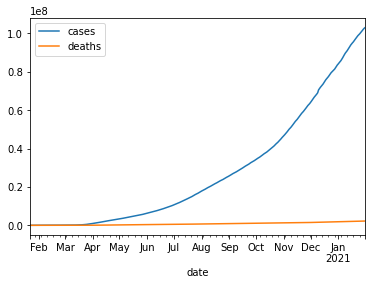

In [126]:
plot_data(comp_world[["cases", "deaths"]])

<AxesSubplot:xlabel='date'>

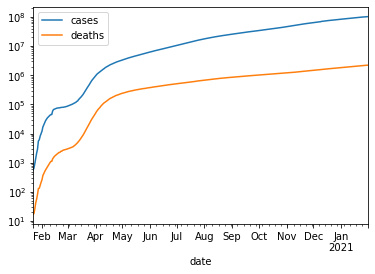

In [127]:
plot_data(comp_world[["cases", "deaths"]], logy=True)

In [128]:
comp_world["death_rate"] = comp_world["deaths"] / comp_world["cases"]

<AxesSubplot:xlabel='date'>

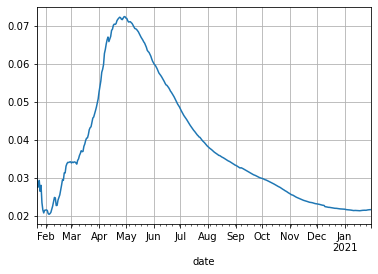

In [129]:
plot_data(comp_world["death_rate"], grid=True)

In [130]:
comp_world.to_excel(xl_writer, "World")

In [131]:
xl_writer.close()

In [132]:
df_summary_cases = pd.DataFrame(df[["Country/Region", df.columns[-1]]].groupby(by="Country/Region").sum().to_records())

In [133]:
df_summary_cases.columns = ["Country", "Cases"]

In [134]:
df_summary_deaths = pd.DataFrame(death[["Country/Region", death.columns[-1]]].groupby(by="Country/Region").sum().to_records())

In [135]:
df_summary_deaths.columns = ["Country", "Deaths"]

In [136]:
df_summary = pd.merge(df_summary_cases, df_summary_deaths, how="outer", on="Country")

In [137]:
iso_code = pd.read_csv("country_name_to_iso_code.csv")
iso_code.loc[iso_code["Country"] == "Namibia", "alpha-2"] = "NA"
iso_code[iso_code["Country"] == "Namibia"]

Unnamed: 0  Country alpha-2
150         152  Namibia      NA

In [138]:
df_summary = pd.merge(df_summary, iso_code, how="outer", on="Country")
df_summary.drop(columns=["Unnamed: 0", ], inplace=True)

In [139]:
df_summary.sort_values(by=["Cases",], ascending=False)

Country       Cases    Deaths alpha-2
178                   US  26186781.0  441324.0      US
79                 India  10757610.0  154392.0      IN
23                Brazil   9204731.0  224504.0      BR
182       United Kingdom   3828183.0  106367.0      GB
142               Russia   3808348.0   72029.0      RU
..                   ...         ...       ...     ...
245               Tuvalu         NaN       NaN      TV
246  U.S. Virgin Islands         NaN       NaN      VI
247        United States         NaN       NaN      US
248      Wallis & Futuna         NaN       NaN      WF
249       Western Sahara         NaN       NaN      EH

[250 rows x 4 columns]

In [140]:
number_of_countries = 15

In [141]:
by_countries = df_summary.copy().drop(columns="alpha-2").set_index("Country")

In [142]:
by_countries.sort_values(by="Cases", ascending=False, inplace=True)

In [143]:
by_countries.head(25)

Cases    Deaths
Country                             
US              26186781.0  441324.0
India           10757610.0  154392.0
Brazil           9204731.0  224504.0
United Kingdom   3828183.0  106367.0
Russia           3808348.0   72029.0
France           3255920.0   76201.0
Spain            2743119.0   58319.0
Italy            2553032.0   88516.0
Turkey           2477463.0   25993.0
Germany          2225659.0   57163.0
Colombia         2094884.0   53983.0
Argentina        1927239.0   47974.0
Mexico           1864260.0  158536.0
Poland           1513385.0   37180.0
South Africa     1453761.0   44164.0
Iran             1417999.0   57959.0
Ukraine          1261546.0   23860.0
Peru             1138239.0   41026.0
Indonesia        1078314.0   29998.0
Netherlands       992075.0   14108.0
Czechia           984774.0   16308.0
Canada            782467.0   20005.0
Romania           728743.0   18335.0
Chile             727109.0   18452.0
Portugal          720516.0   12482.0

In [144]:
[by_countries.iloc[:number_of_countries].sum(), ]

[Cases     75894375.0
 Deaths     1646645.0
 dtype: float64]

In [145]:
by_countries = pd.concat([
    by_countries.iloc[:number_of_countries],
    pd.DataFrame([by_countries.iloc[number_of_countries:].sum(), ])
]
)

In [146]:
by_countries.rename(index={0: 'others'}, inplace=True)

In [147]:
by_countries

Cases    Deaths
US              26186781.0  441324.0
India           10757610.0  154392.0
Brazil           9204731.0  224504.0
United Kingdom   3828183.0  106367.0
Russia           3808348.0   72029.0
France           3255920.0   76201.0
Spain            2743119.0   58319.0
Italy            2553032.0   88516.0
Turkey           2477463.0   25993.0
Germany          2225659.0   57163.0
Colombia         2094884.0   53983.0
Argentina        1927239.0   47974.0
Mexico           1864260.0  158536.0
Poland           1513385.0   37180.0
South Africa     1453761.0   44164.0
others          27071480.0  581260.0

array([<AxesSubplot:ylabel='Cases'>, <AxesSubplot:ylabel='Deaths'>],
      dtype=object)

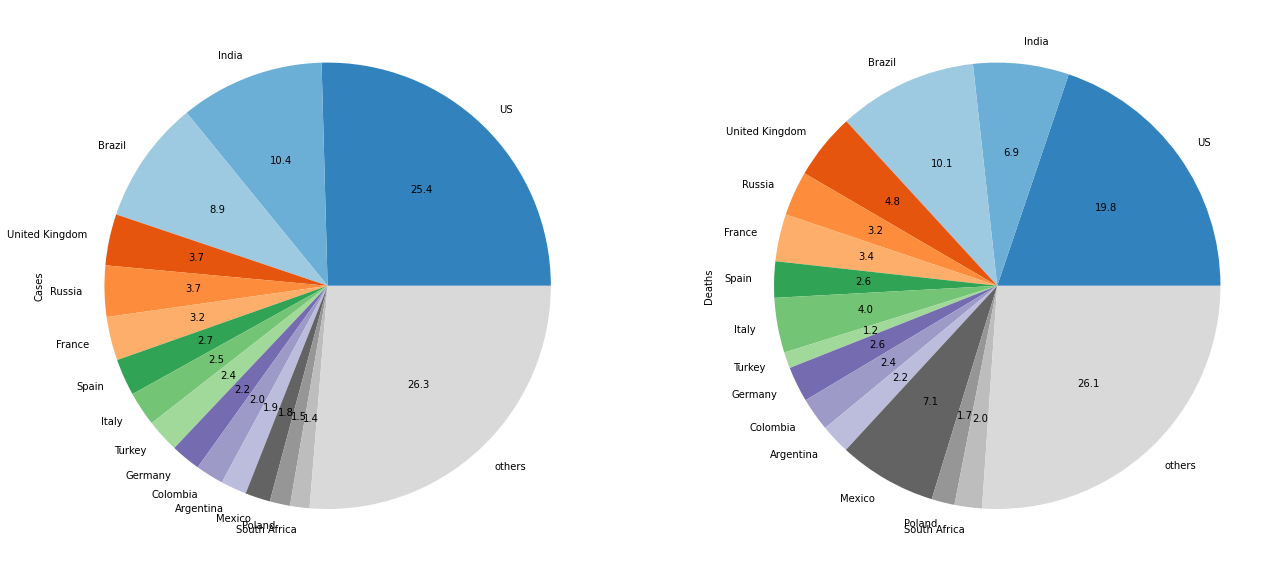

In [148]:
by_countries.plot.pie(subplots=True, figsize=(22, 11), cmap=plt.cm.get_cmap('tab20c'), legend=False, autopct='%.1f')

<AxesSubplot:xlabel='Cases', ylabel='Deaths'>

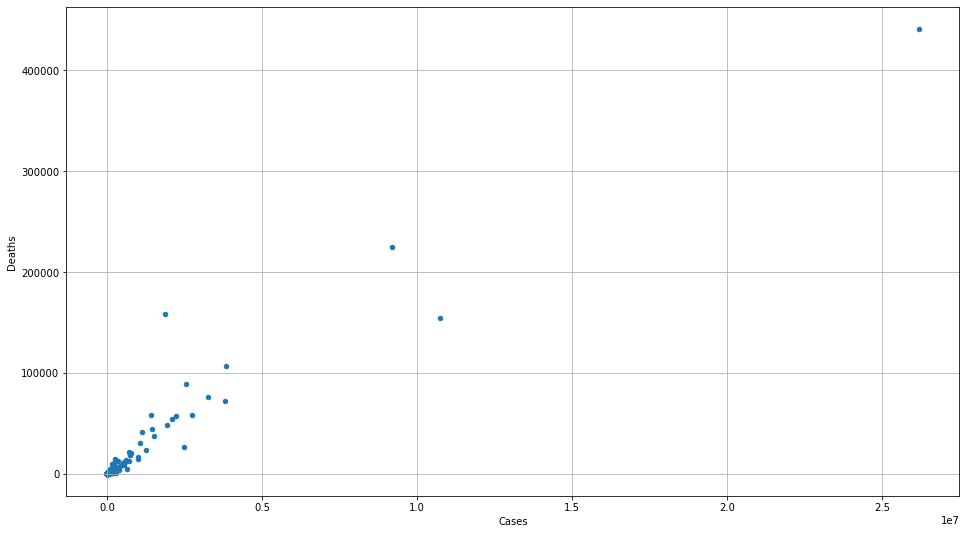

In [149]:
df_summary.plot.scatter(x="Cases", y="Deaths", figsize=(16, 9), grid=True)

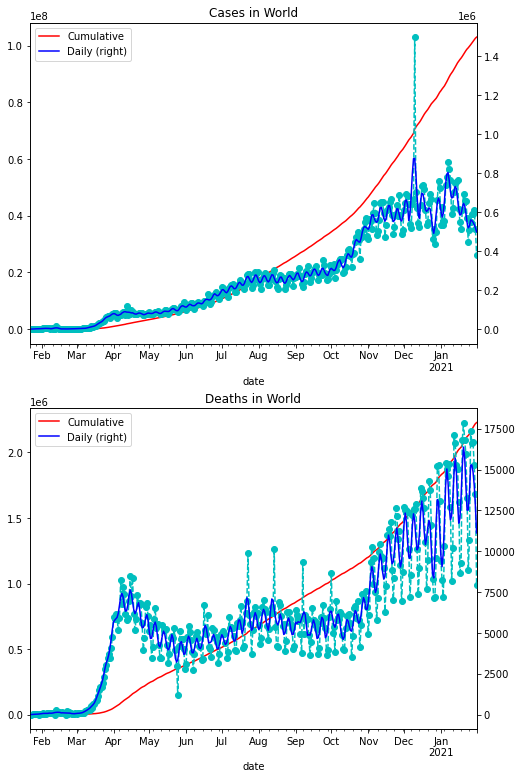

In [150]:
plot_daily(comp_world)

In [151]:
se = add(df, death, "Sweden")

In [152]:
uk = add(df, death, "United Kingdom")

In [153]:
it = add(df, death, "Italy")

In [154]:
sp = add(df, death, "Spain")

In [155]:
fr = add(df, death, "France")

In [156]:
ch = add(df, death, "Switzerland")

In [157]:
be = add(df, death, "Belgium")

In [158]:
de = add(df, death, "Germany")

In [159]:
kr = add(df, death, "Korea, South")

In [160]:
nl = add(df, death, "Netherlands")

In [161]:
us = add(df, death, "US")

In [162]:
sg = add(df, death, "Singapore")

In [163]:
br = add(df, death, "Brazil")

In [164]:
pe = add(df, death, "Peru")

In [165]:
ru = add(df, death, "Russia")

In [166]:
tu = add(df, death, "Turkey")

In [167]:
ir = add(df, death, "Iran")

In [168]:
ar = add(df, death, "Argentina")

In [169]:
mex = add(df, death, "Mexico")

In [170]:
chi = add(df, death, "Chile")

In [171]:
co = add(df, death, "Colombia")

In [172]:
india = add(df, death, "India")

In [173]:
pak = add(df, death, "Pakistan")

In [174]:
ind = add(df, death, "Indonesia")

In [175]:
dz = add(df, death, "Algeria")

In [176]:
mar = add(df, death, "Morocco")

In [177]:
# can = add(df, death, "Canada")

In [178]:
th = add(df, death, "Thailand")

<AxesSubplot:xlabel='cases', ylabel='Death'>

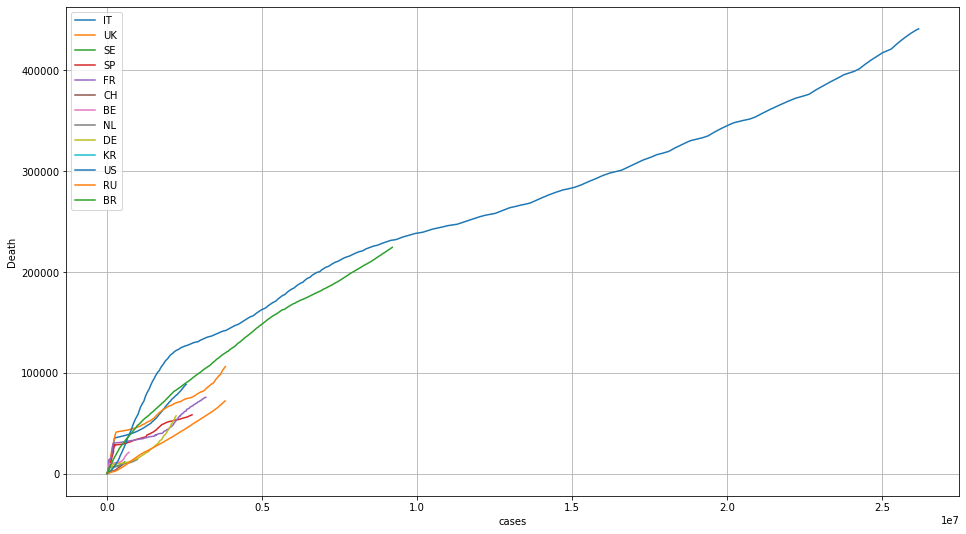

In [179]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_ylabel("Death")
it.plot(x="cases", y="deaths", ax=ax, grid=True, label="IT")
uk.plot(x="cases", y="deaths", ax=ax, grid=True, label="UK")
se.plot(x="cases", y="deaths", ax=ax, grid=True, label="SE")
sp.plot(x="cases", y="deaths", ax=ax, grid=True, label="SP")
fr.plot(x="cases", y="deaths", ax=ax, grid=True, label="FR")
ch.plot(x="cases", y="deaths", ax=ax, grid=True, label="CH")
be.plot(x="cases", y="deaths", ax=ax, grid=True, label="BE")
nl.plot(x="cases", y="deaths", ax=ax, grid=True, label="NL")
de.plot(x="cases", y="deaths", ax=ax, grid=True, label="DE")
kr.plot(x="cases", y="deaths", ax=ax, grid=True, label="KR")
us.plot(x="cases", y="deaths", ax=ax, grid=True, label="US")
ru.plot(x="cases", y="deaths", ax=ax, grid=True, label="RU")
br.plot(x="cases", y="deaths", ax=ax, grid=True, label="BR")

<AxesSubplot:xlabel='cases', ylabel='Death'>

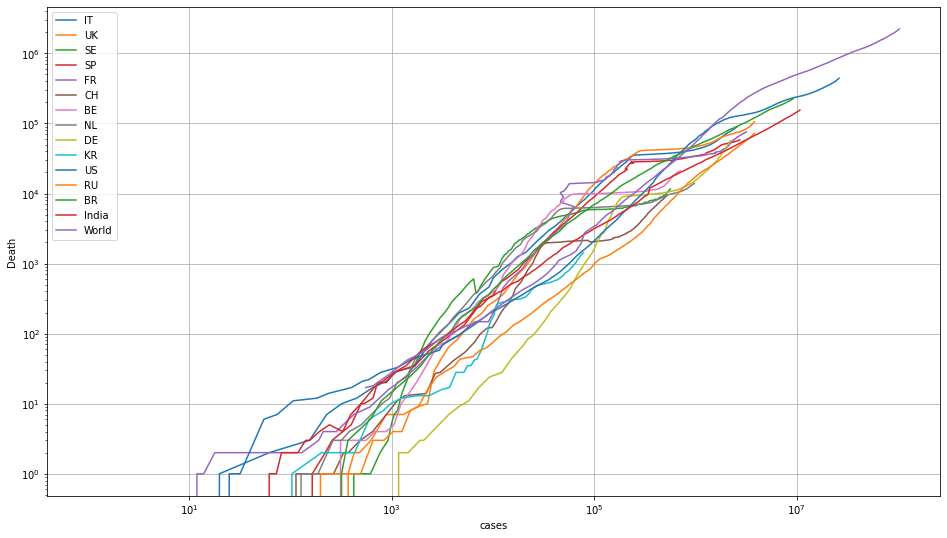

In [180]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_ylabel("Death")
it.plot(x="cases", y="deaths", ax=ax, grid=True, label="IT", loglog=True)
uk.plot(x="cases", y="deaths", ax=ax, grid=True, label="UK")
se.plot(x="cases", y="deaths", ax=ax, grid=True, label="SE")
sp.plot(x="cases", y="deaths", ax=ax, grid=True, label="SP")
fr.plot(x="cases", y="deaths", ax=ax, grid=True, label="FR")
ch.plot(x="cases", y="deaths", ax=ax, grid=True, label="CH")
be.plot(x="cases", y="deaths", ax=ax, grid=True, label="BE")
nl.plot(x="cases", y="deaths", ax=ax, grid=True, label="NL")
de.plot(x="cases", y="deaths", ax=ax, grid=True, label="DE")
kr.plot(x="cases", y="deaths", ax=ax, grid=True, label="KR")
us.plot(x="cases", y="deaths", ax=ax, grid=True, label="US")
ru.plot(x="cases", y="deaths", ax=ax, grid=True, label="RU")
br.plot(x="cases", y="deaths", ax=ax, grid=True, label="BR")
india.plot(x="cases", y="deaths", ax=ax, grid=True, label="India")
comp_world.plot(x="cases", y="deaths", ax=ax, grid=True, label="World")

In [181]:
by_countries.index

Index(['US', 'India', 'Brazil', 'United Kingdom', 'Russia', 'France', 'Spain',
       'Italy', 'Turkey', 'Germany', 'Colombia', 'Argentina', 'Mexico',
       'Poland', 'South Africa', 'others'],
      dtype='object')

In [182]:
def plot_daily(data):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 13))
    dataframe = data.copy()
    dataframe.reset_index("day_of_year", drop=True, inplace=True)
    dataframe["cases"].plot(color="r", 
                            title=f"Cases in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax1)
    ax11 = dataframe["daily_cases"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax1)  
    dataframe["daily_cases_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax1)
    ax1.set_ylabel("Cumulative cases")
    ax11.set_ylabel("Daily Cases")
    #
    dataframe["deaths"].plot(color="r", 
                            title=f"Deaths in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax2)
    ax22 = dataframe["daily_death"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax2)  
    dataframe["daily_death_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax2)
    ax2.set_ylabel("Cumulative cases")
    ax22.set_ylabel("Daily deaths")

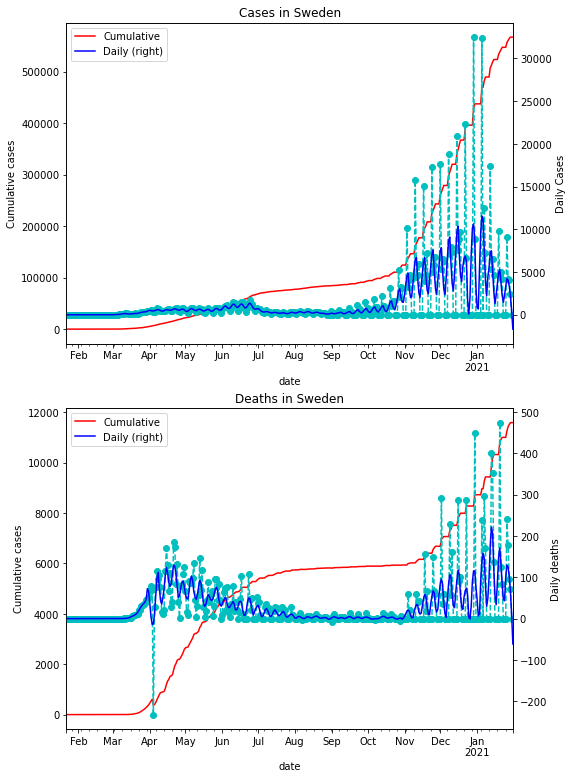

In [183]:
plot_daily(se)

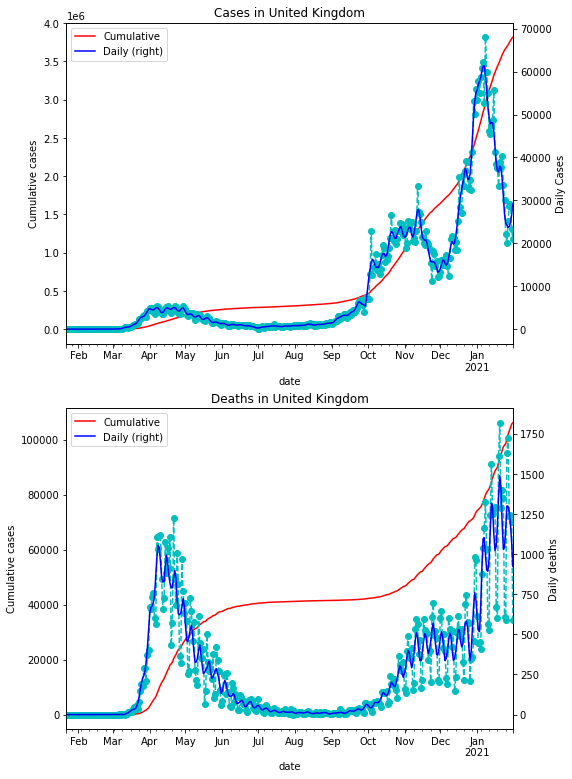

In [184]:
plot_daily(uk)

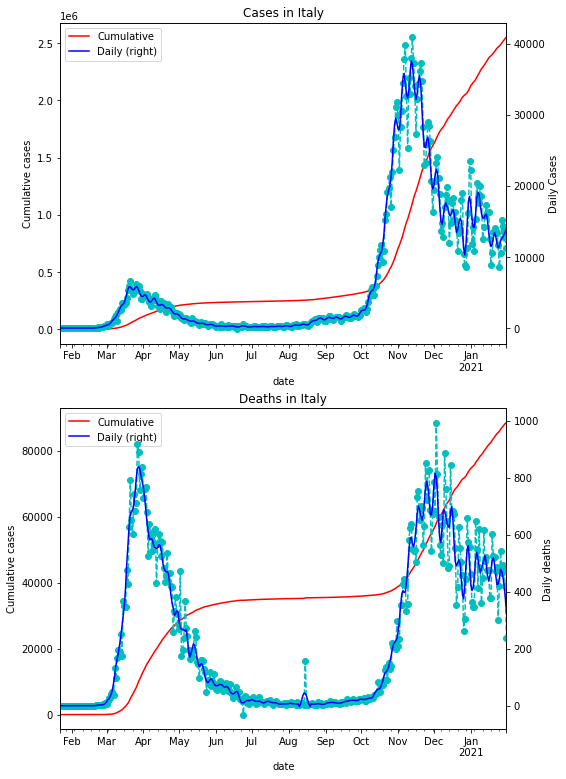

In [185]:
plot_daily(it)

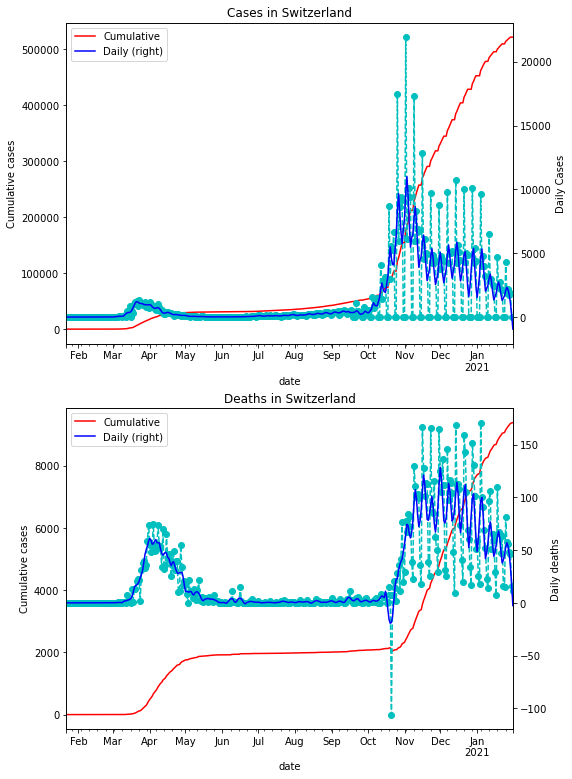

In [186]:
plot_daily(ch)

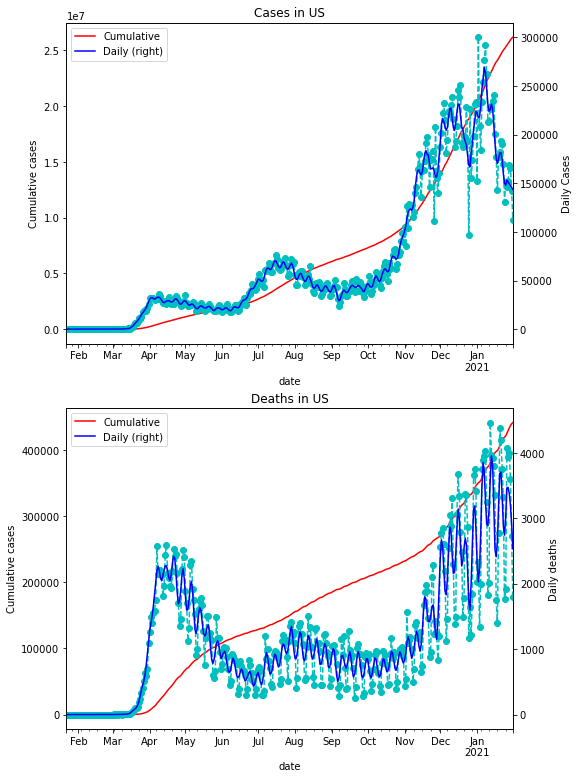

In [187]:
plot_daily(us)

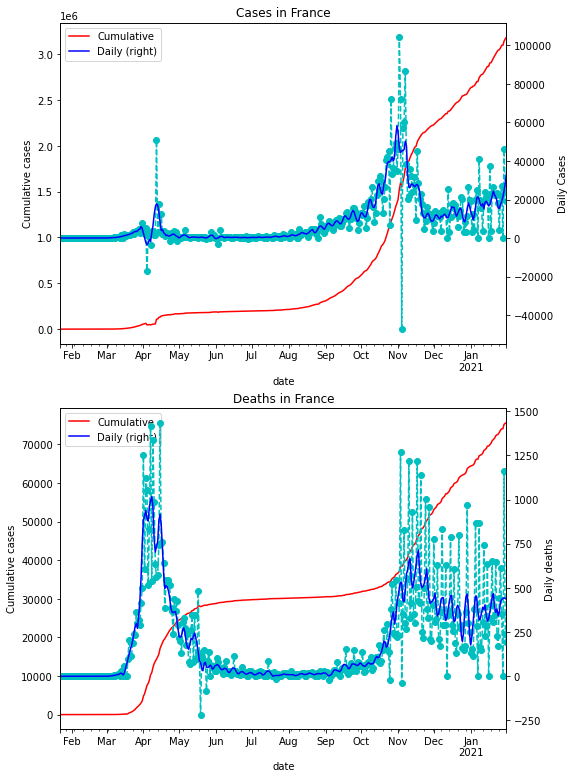

In [188]:
plot_daily(fr)

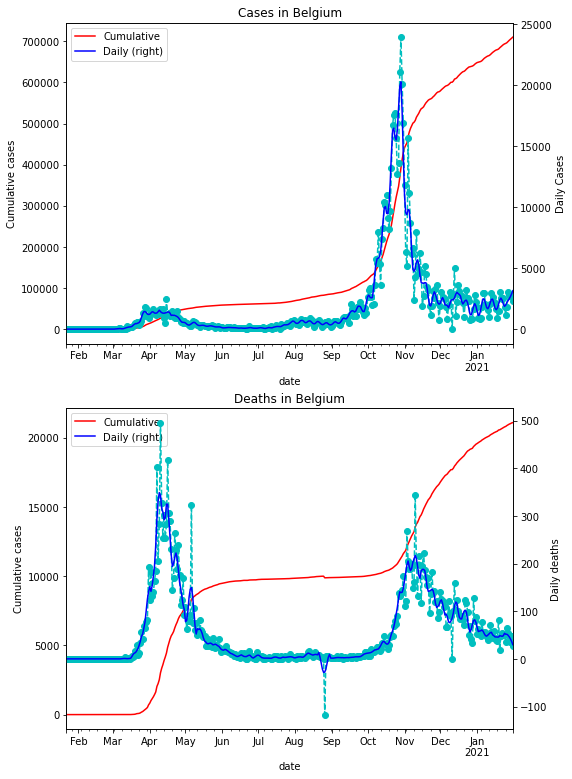

In [189]:
plot_daily(be)

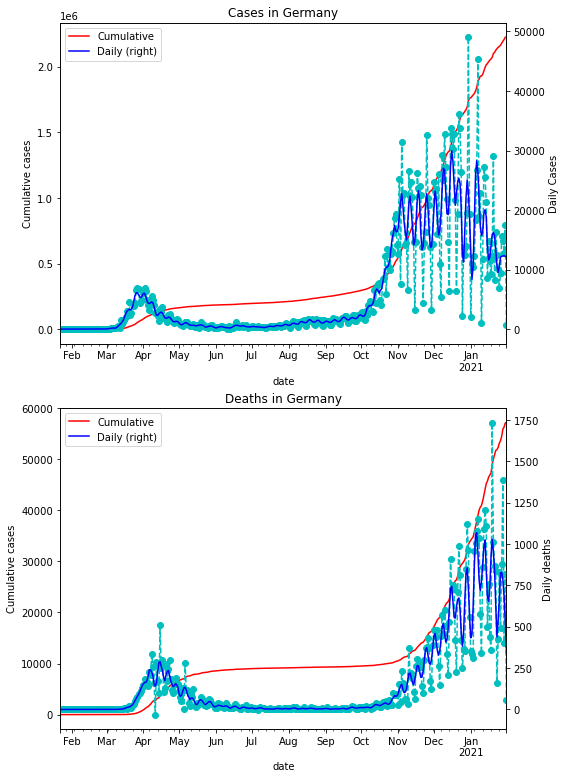

In [190]:
plot_daily(de)

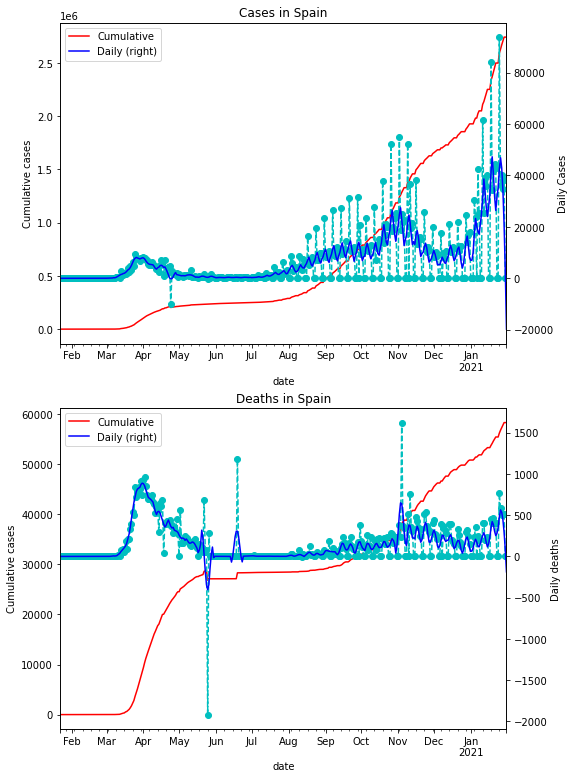

In [191]:
plot_daily(sp)

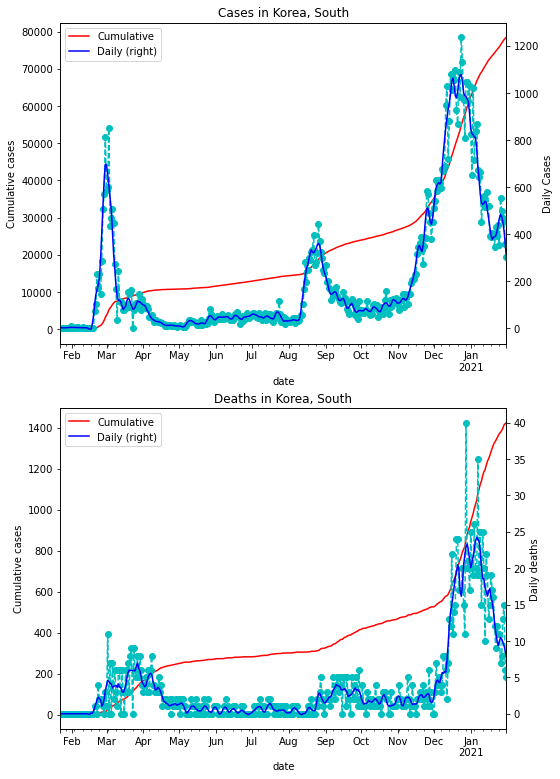

In [192]:
plot_daily(kr)

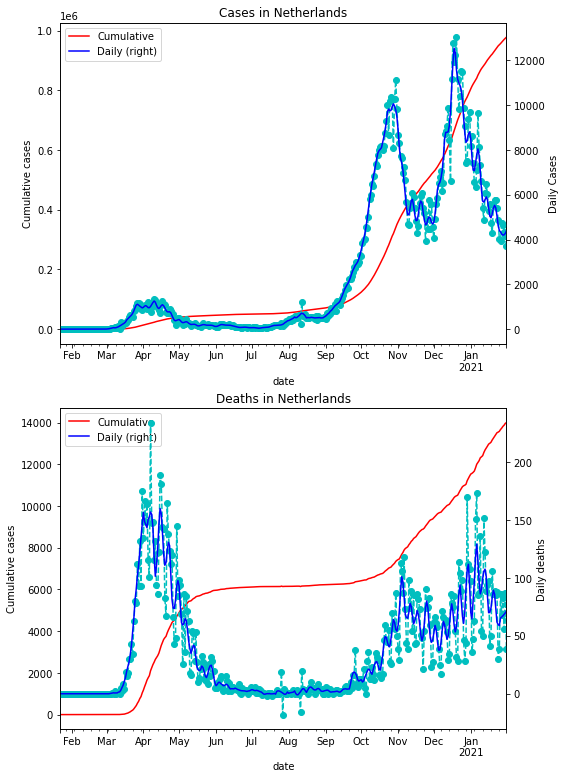

In [193]:
plot_daily(nl)

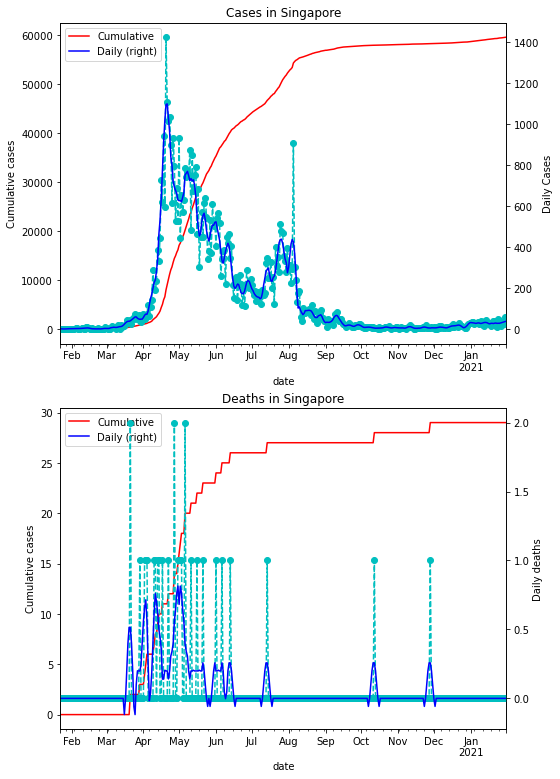

In [194]:
plot_daily(sg)

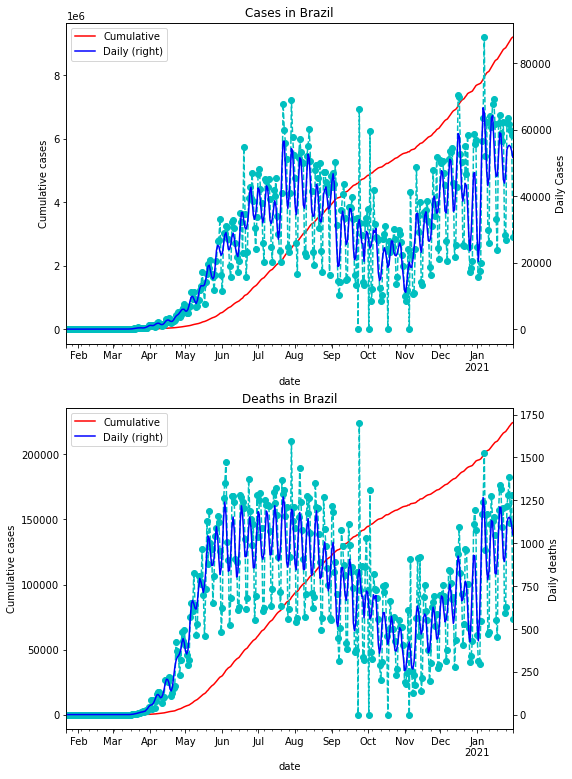

In [195]:
plot_daily(br)

<AxesSubplot:xlabel='date'>

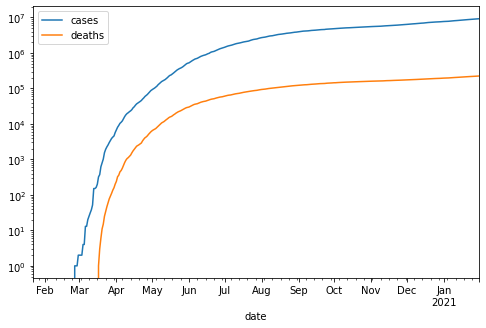

In [196]:
plot_data(br[["cases", "deaths"]], logy=True, figsize=(8, 5))

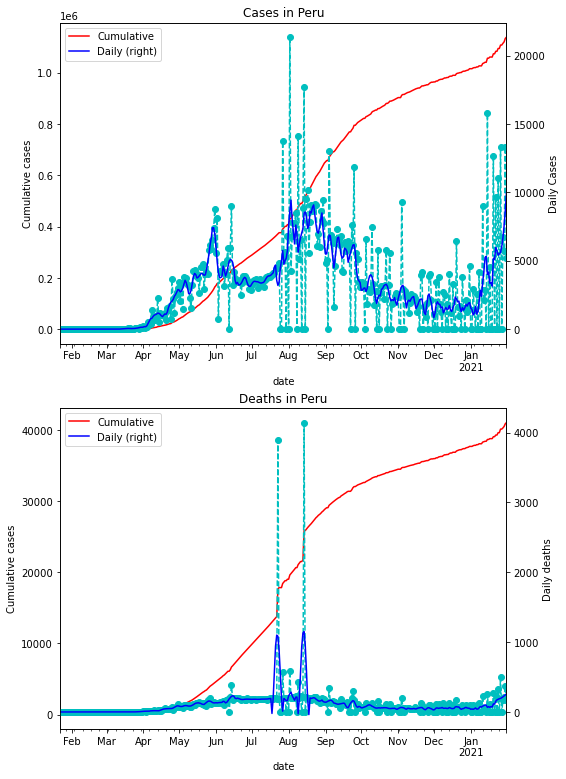

In [197]:
plot_daily(pe)

<AxesSubplot:xlabel='date'>

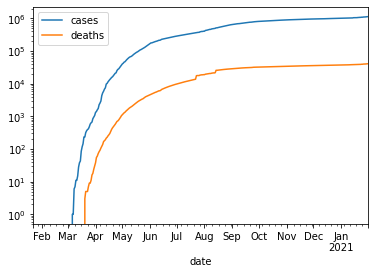

In [198]:
plot_data(pe[["cases", "deaths"]], logy=True)

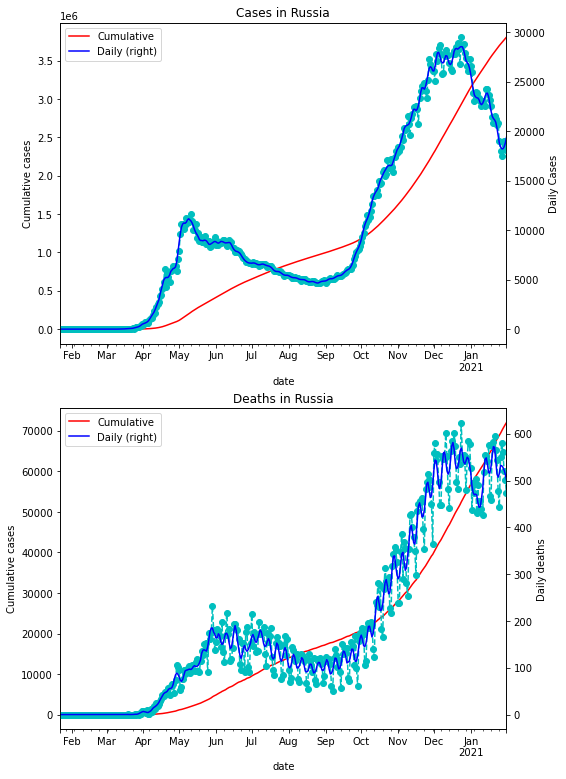

In [199]:
plot_daily(ru)

<AxesSubplot:xlabel='date'>

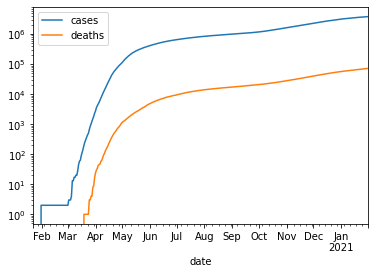

In [200]:
plot_data(ru[["cases", "deaths"]], logy=True)

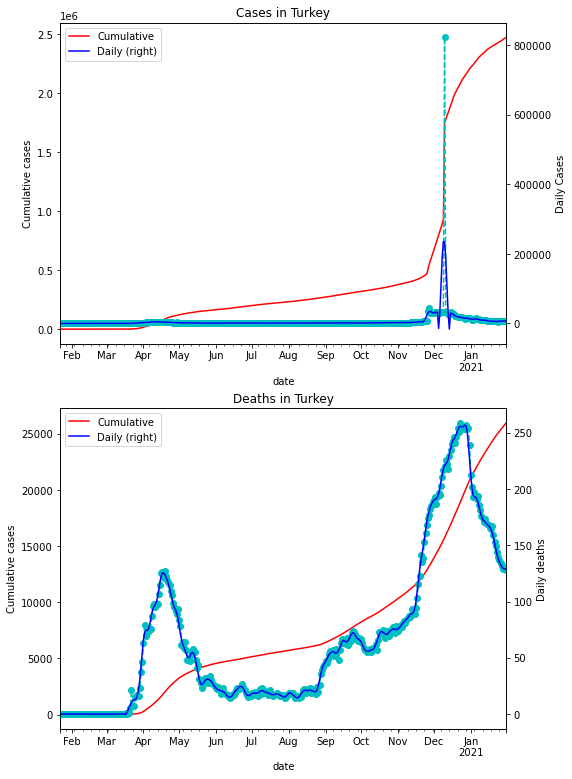

In [201]:
plot_daily(tu)

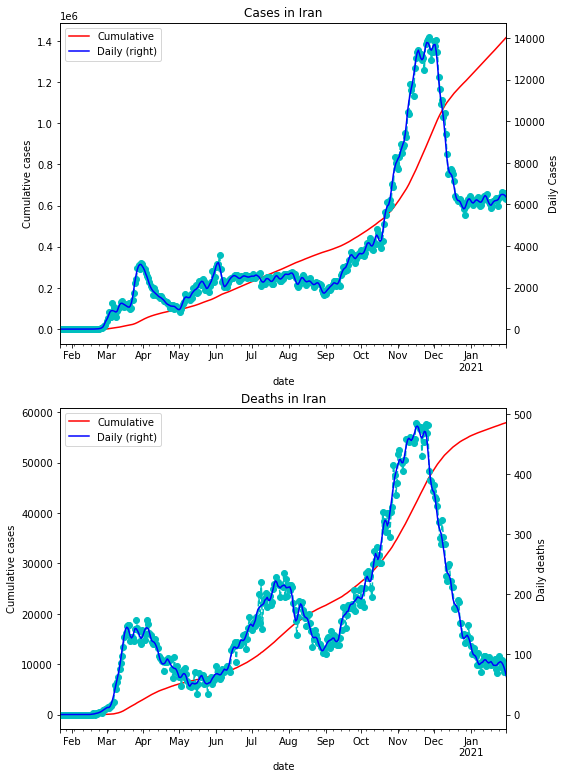

In [202]:
plot_daily(ir)

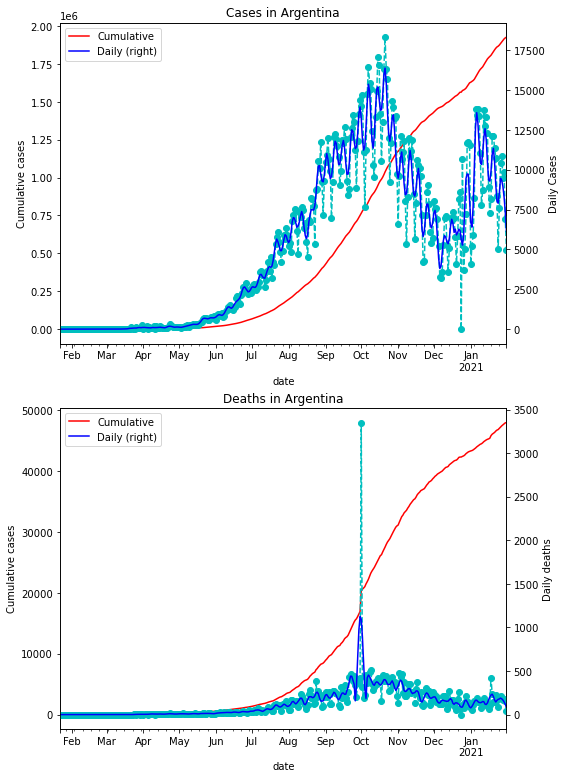

In [203]:
plot_daily(ar)

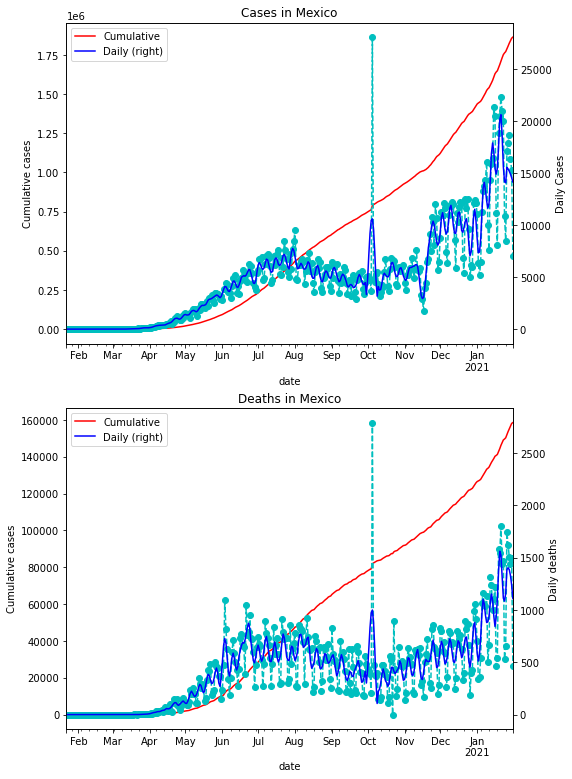

In [204]:
plot_daily(mex)

<AxesSubplot:xlabel='date'>

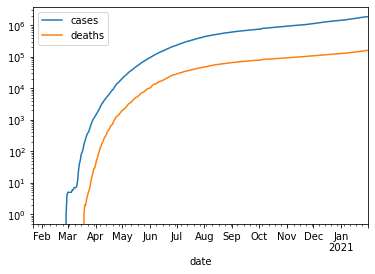

In [205]:
plot_data(mex[["cases", "deaths"]], logy=True)

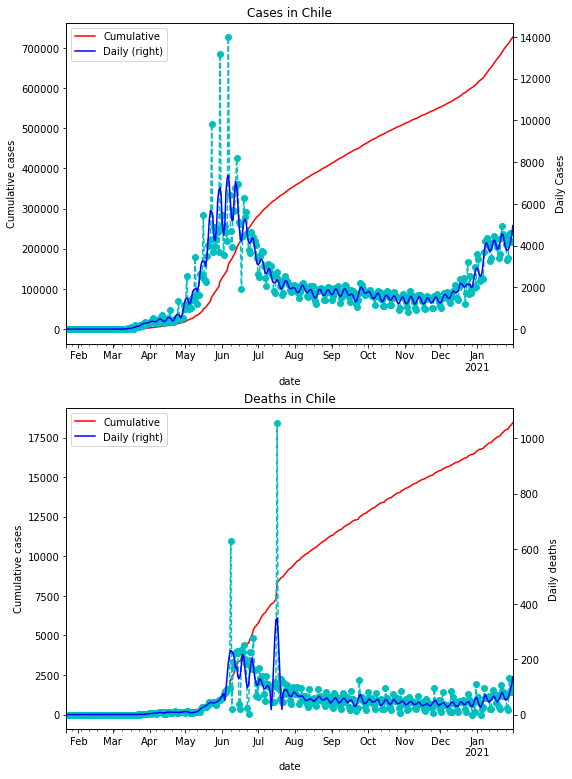

In [206]:
plot_daily(chi)

<AxesSubplot:xlabel='date'>

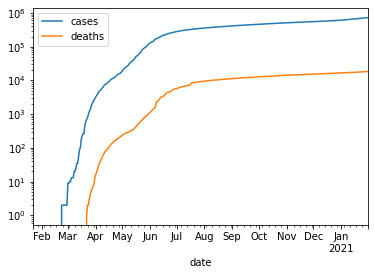

In [207]:
plot_data(chi[["cases", "deaths"]], logy=True)

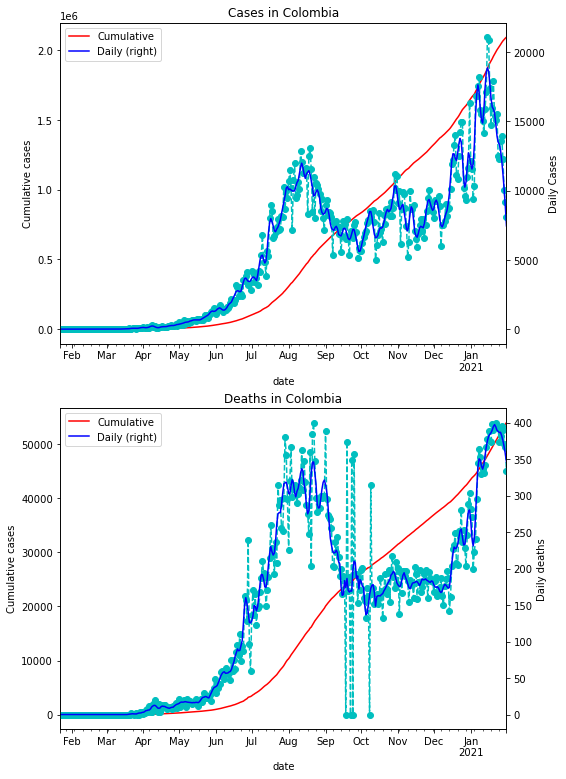

In [208]:
plot_daily(co)

<AxesSubplot:xlabel='date'>

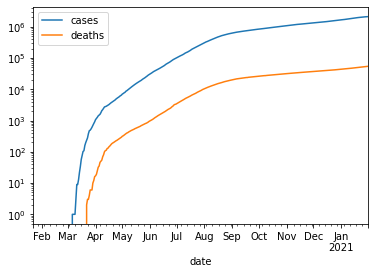

In [209]:
plot_data(co[["cases", "deaths"]], logy=True)

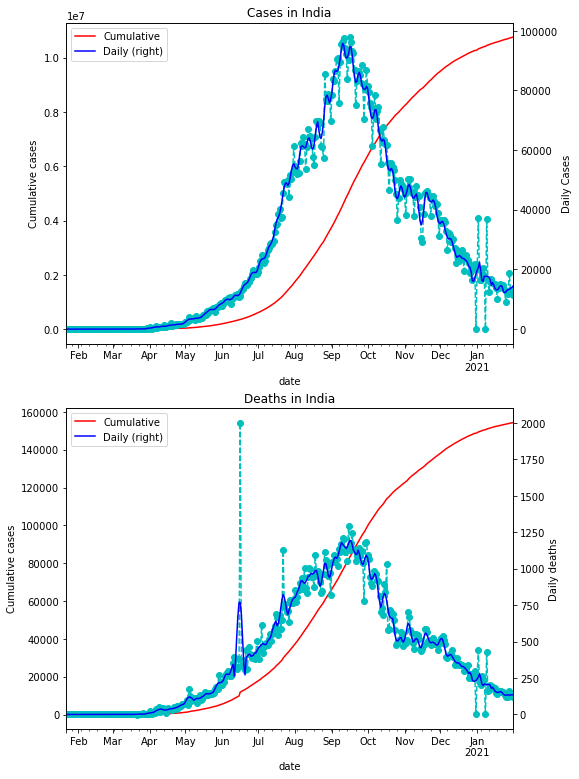

In [210]:
plot_daily(india)

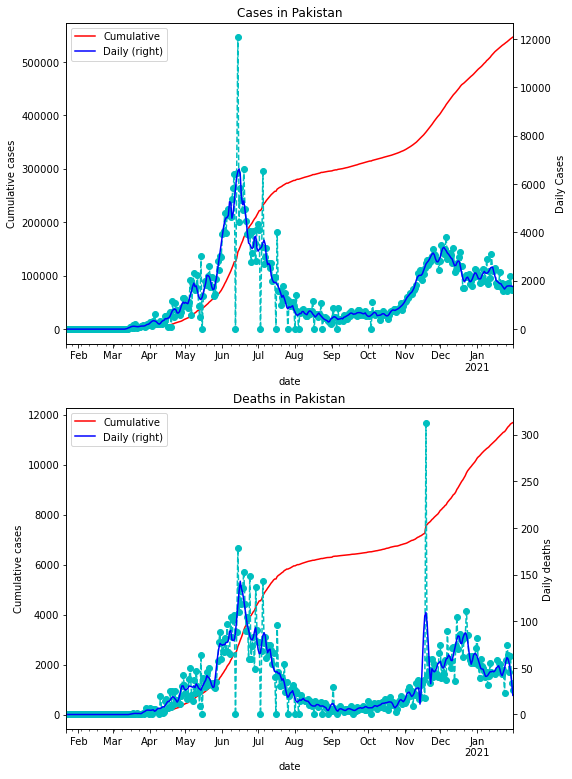

In [211]:
plot_daily(pak)

<AxesSubplot:title={'center':'Pakistan'}, xlabel='date'>

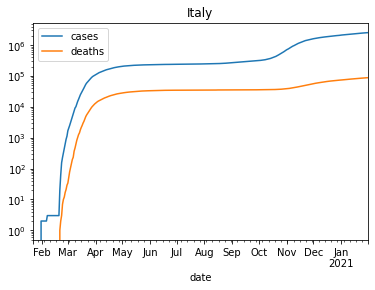

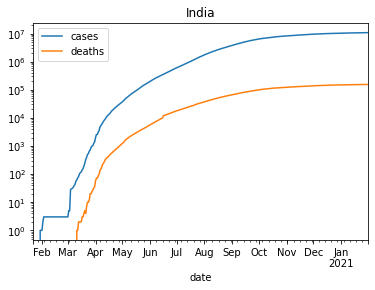

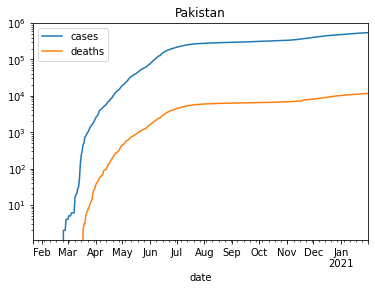

In [212]:
plot_data(it[["cases", "deaths"]], logy=True, title="Italy")
plot_data(india[["cases", "deaths"]], logy=True, title="India")
plot_data(pak[["cases", "deaths"]], logy=True, title="Pakistan")


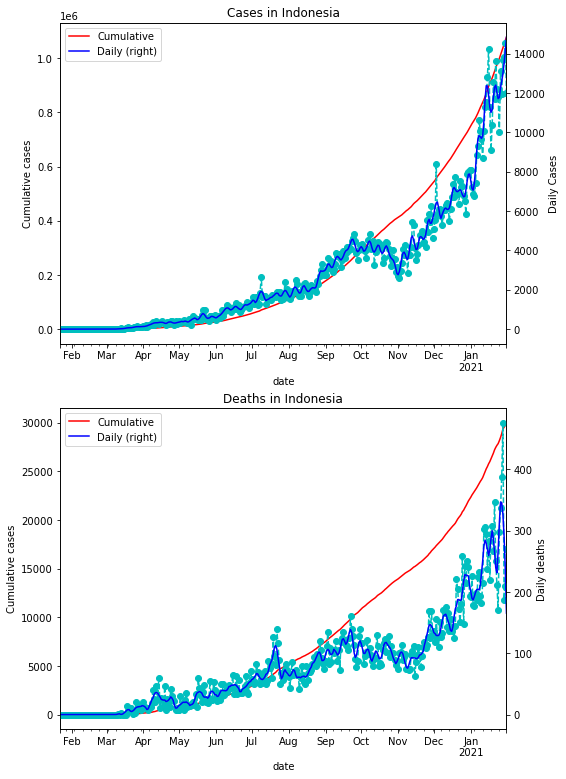

In [213]:
plot_daily(ind)

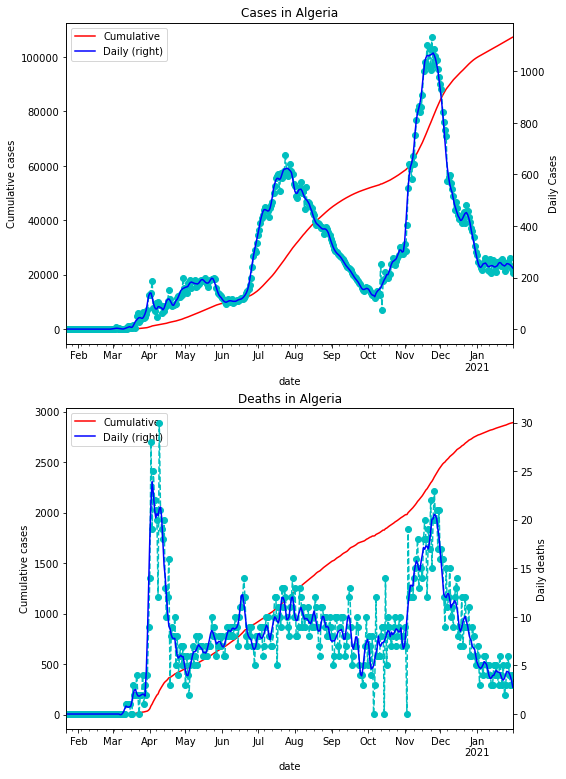

In [214]:
plot_daily(dz)

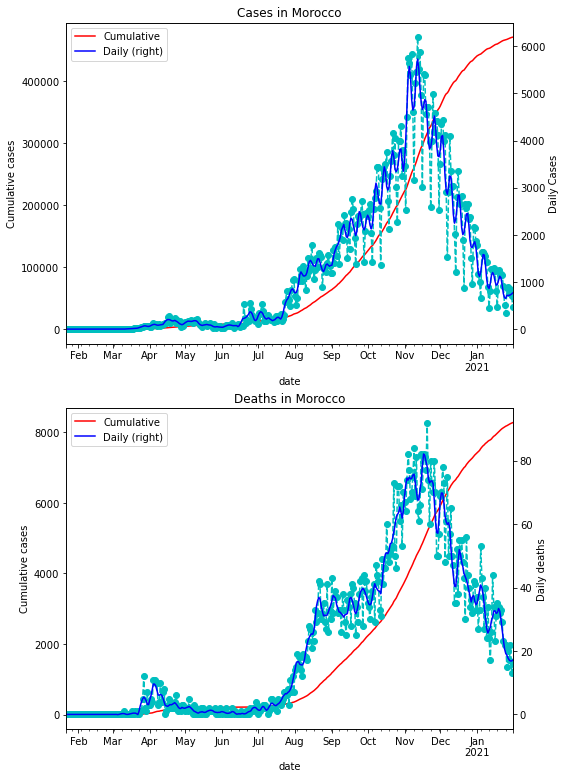

In [215]:
plot_daily(mar)

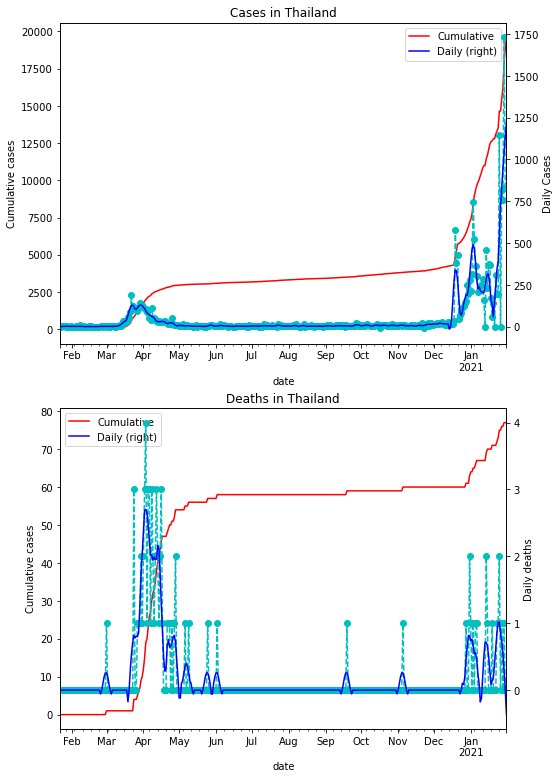

In [216]:
plot_daily(th)

In [217]:
se.tail(10)

cases  deaths  daily_cases  daily_cases_s  \
date       day_of_year                                               
2021-01-22 22           547166   11005       4214.0    2295.659479   
2021-01-23 23           547166   11005          0.0    1465.521368   
2021-01-24 24           547166   11005          0.0    2257.064685   
2021-01-25 25           547166   11005          0.0    3303.381507   
2021-01-26 26           556289   11247       9123.0    4240.892580   
2021-01-27 27           560472   11425       4183.0    4036.256799   
2021-01-28 28           564557   11520       4085.0    3341.790016   
2021-01-29 29           566957   11591       2400.0    2157.492230   
2021-01-30 30           566957   11591          0.0     483.363442   
2021-01-31 31           566957   11591          0.0   -1680.596348   

                        daily_death  daily_death_s  
date       day_of_year                              
2021-01-22 22                  84.0      84.181818  
2021-01-23 23                   0.0      47.890443  
2021-01-24 24                   0.0      43.126651  
2021-01-25 25                   0.0     100.165501  
2021-01-26 26                 242.0     129.448524  
2021-01-27 27                 178.0     123.998057  
2021-01-28 28                  95.0     102.192113  
2021-01-29 29                  71.0      64.030692  
2021-01-30 30                   0.0       9.513792  
2021-01-31 31                   0.0     -61.358586

In [218]:
us.tail(15)

cases  deaths  daily_cases  daily_cases_s  \
date       day_of_year                                                 
2021-01-17 17           23961423  397628     177404.0  176150.732906   
2021-01-18 18           24104028  399033     142605.0  170339.625486   
2021-01-19 19           24281012  401807     176984.0  175082.835859   
2021-01-20 20           24463591  406184     182579.0  181132.237374   
2021-01-21 21           24656646  410387     193055.0  181354.429293   
2021-01-22 22           24846678  414147     190032.0  174009.548951   
2021-01-23 23           25016816  417476     170138.0  159885.842657   
2021-01-24 24           25147891  419251     131075.0  150190.010684   
2021-01-25 25           25298986  421168     151095.0  147965.030109   
2021-01-26 26           25445583  425252     146597.0  153288.699301   
2021-01-27 27           25598061  429195     152478.0  151436.731935   
2021-01-28 28           25766681  433196     168620.0  149542.890443   
2021-01-29 29           25932794  436799     166113.0  147607.174825   
2021-01-30 30           26074885  439530     142091.0  145629.585082   
2021-01-31 31           26186781  441324     111896.0  143610.121212   

                        daily_death  daily_death_s  
date       day_of_year                              
2021-01-17 17                1751.0    2413.187257  
2021-01-18 18                1405.0    2640.584110  
2021-01-19 19                2774.0    3191.609751  
2021-01-20 20                4377.0    3686.910256  
2021-01-21 21                4203.0    3710.720862  
2021-01-22 22                3760.0    3342.925991  
2021-01-23 23                3329.0    2890.632284  
2021-01-24 24                1775.0    2744.450466  
2021-01-25 25                1917.0    3023.766317  
2021-01-26 26                4084.0    3467.689394  
2021-01-27 27                3943.0    3473.240093  
2021-01-28 28                4001.0    3382.745338  
2021-01-29 29                3603.0    3196.205128  
2021-01-30 30                2731.0    2913.619464  
2021-01-31 31                1794.0    2534.988345

In [219]:
it["death_rate"] = it["deaths"] / it["cases"]
ch["death_rate"] = ch["deaths"] / ch["cases"]
se["death_rate"] = se["deaths"] / se["cases"]
uk["death_rate"] = uk["deaths"] / uk["cases"]
be["death_rate"] = be["deaths"] / be["cases"]
sp["death_rate"] = sp["deaths"] / sp["cases"]
de["death_rate"] = de["deaths"] / de["cases"]
us["death_rate"] = us["deaths"] / us["cases"]

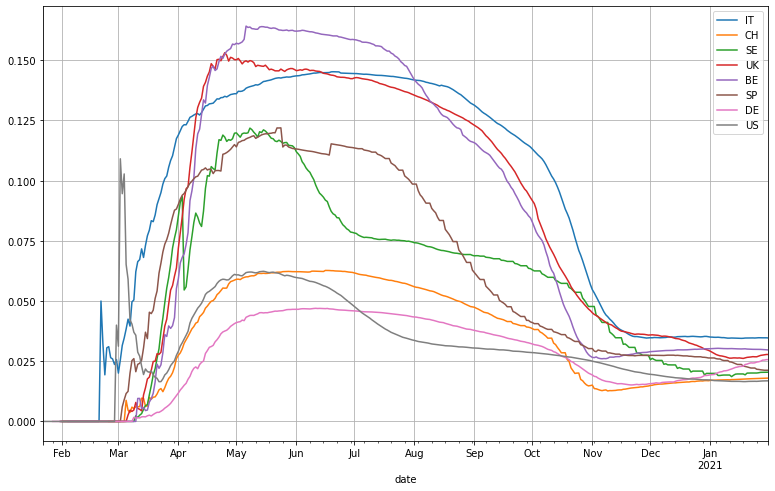

In [220]:
df_rate = pd.concat([it["death_rate"], 
                     ch["death_rate"], 
                     se["death_rate"], 
                     uk["death_rate"],
                     be["death_rate"],
                     sp["death_rate"],
                     de["death_rate"],
                     us["death_rate"],
                    ], axis=1)
df_rate.columns = ["IT", "CH", "SE", "UK", "BE", "SP", "DE", "US"]
df_rate.dropna()
ax =plot_data(df_rate, grid=True, figsize=(13, 8))


In [221]:
nl

cases  deaths  daily_cases  daily_cases_s  \
date       day_of_year                                               
2020-01-22 22                0       0          0.0       0.000000   
2020-01-23 23                0       0          0.0       0.000000   
2020-01-24 24                0       0          0.0       0.000000   
2020-01-25 25                0       0          0.0       0.000000   
2020-01-26 26                0       0          0.0       0.000000   
...                        ...     ...          ...            ...   
2021-01-27 27           961593   13733       4726.0    4241.859751   
2021-01-28 28           966252   13816       4659.0    4197.299728   
2021-01-29 29           970602   13872       4350.0    4207.738539   
2021-01-30 30           974775   13959       4173.0    4273.176185   
2021-01-31 31           978475   13998       3700.0    4393.612665   

                        daily_death  daily_death_s  
date       day_of_year                              
2020-01-22 22                   0.0       0.000000  
2020-01-23 23                   0.0       0.000000  
2020-01-24 24                   0.0       0.000000  
2020-01-25 25                   0.0       0.000000  
2020-01-26 26                   0.0       0.000000  
...                             ...            ...  
2021-01-27 27                  68.0      66.242036  
2021-01-28 28                  83.0      67.267677  
2021-01-29 29                  56.0      68.456488  
2021-01-30 30                  87.0      69.808469  
2021-01-31 31                  39.0      71.323621  

[376 rows x 6 columns]

In [222]:
nl["cases"].tail(15).diff(14).iloc[-1] * 100000 / 17134872

384.7183684827059

In [223]:
fr["cases"].tail(15).diff(14).iloc[-1] * 100000 / 65273511

432.60887253330066

In [224]:
sp["cases"].tail(15).diff(14).iloc[-1] * 100000 / 46754778

1050.0638031047865

In [225]:
ru["cases"].tail(15).diff(14).iloc[-1] * 100000 / 145934462

190.47522853101003

In [226]:
se["cases"].tail(15).diff(14).iloc[-1] * 100000 / 10099265

430.4372644940003

In [227]:
be["cases"].tail(15).diff(14).iloc[-1] * 100000 / 11589623

270.18997943246296

In [228]:
it["cases"].tail(15).diff(14).iloc[-1] * 100000 / 60461826

284.0718042488495

In [229]:
uk["cases"].tail(15).diff(14).iloc[-1] * 100000 / 67886011

620.4768755671915

In [230]:
dz["cases"].tail(15).diff(14).iloc[-1] * 100000 / 43851044

7.995248642198804

In [231]:
mar["cases"].tail(15).diff(14).iloc[-1] * 100000 / 36910560

31.11846582658188

In [232]:
us["cases"].tail(15).diff(14).iloc[-1] * 100000 / 331433217

671.4348127635017

In [233]:
br["cases"].tail(15).diff(14).iloc[-1] * 100000 / 212559417

337.144319510436

In [234]:
mex["cases"].tail(15).diff(14).iloc[-1] * 100000 / 128932753

172.82807883579434